In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
import pickle
%matplotlib inline

Setting up training and testing files

In [2]:
X_train = pd.read_csv('train10000.csv', header=None)
y_train = pd.read_csv('train10000_label.csv', names=['Target'], squeeze=True)
X_test = pd.read_csv('test10000.csv', header=None)
y_test = pd.read_csv('test10000_label.csv', names=['Target'], squeeze=True)

df_train = pd.concat([X_train, y_train], axis=1, ignore_index=False)
df_test = pd.concat([X_test, y_test], axis=1, ignore_index=False)

Highlighting the severely imbalanced target variable in the training data (will need to undersample or oversample for this)

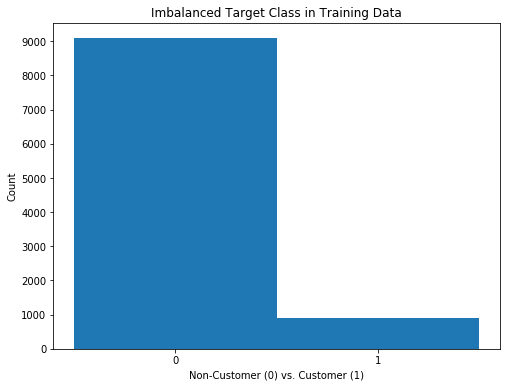

In [3]:
figure(figsize=(8,6))
plt.hist(df_train['Target'],bins=np.arange(3)-0.5)
plt.title("Imbalanced Target Class in Training Data")
plt.xlabel('Non-Customer (0) vs. Customer (1)')
plt.ylabel('Count')
plt.xticks([0,1])
plt.yticks(np.arange(0,10000, 1000))
plt.show()

Checking for any features which have missing values in their rows. These appear to be encoded as 999000.0

In [4]:
nm_cols = [] # list of columns indices for those w/o missing vals
m_cols = [] # list of column indices which have missing vals
for c_idx, series in df_train.iteritems():
    if series.isnull().any():
        print "Column: ", c_idx, " null values present"
        m_cols.append(c_idx)
        continue
    elif series.isin([999000]).any():
        print "Column: ", c_idx," - 999000 encoded missing values present"
        m_cols.append(c_idx)
        continue
    nm_cols.append(c_idx)

Column:  0  - 999000 encoded missing values present
Column:  2  - 999000 encoded missing values present
Column:  5  - 999000 encoded missing values present
Column:  6  - 999000 encoded missing values present
Column:  7  - 999000 encoded missing values present
Column:  8  - 999000 encoded missing values present
Column:  9  - 999000 encoded missing values present
Column:  12  - 999000 encoded missing values present
Column:  14  - 999000 encoded missing values present
Column:  27  - 999000 encoded missing values present
Column:  28  - 999000 encoded missing values present


For columns with missing values I am checking what percentage of the values are missing. If there is a high percentage of missing values it won't make sense to impute based on other values in that row. 

Additionally, it is most likely not in our best interest to impute for features which are binary, so that should be avoided (columns with three variables represent binary since the third value is the missing one). Columns with low variable count but greater than 3 are likely ordinal and will be manually inspected

In [5]:
for idx in m_cols:
    percentages = df_train[idx].value_counts(normalize=True)
    n_vars = len(percentages)
    print "Column:",idx, "\t: #vars =", n_vars, "\t\t{0}% missing".format(percentages[999000]*100)

Column: 0 	: #vars = 3 		52.11% missing
Column: 2 	: #vars = 8 		24.38% missing
Column: 5 	: #vars = 3 		24.02% missing
Column: 6 	: #vars = 5 		43.13% missing
Column: 7 	: #vars = 10 		70.73% missing
Column: 8 	: #vars = 10 		30.24% missing
Column: 9 	: #vars = 4 		54.31% missing
Column: 12 	: #vars = 19 		77.04% missing
Column: 14 	: #vars = 3 		52.11% missing
Column: 27 	: #vars = 2853 		5.04% missing
Column: 28 	: #vars = 11 		5.04% missing


The training data appears to have several columns with missing values encoded as 999000. Many of these have a very high amount of missing data. I will make copies of the training dataset:
- 1: raw data set
- 2: raw data set with columns removed that have missing vals
- 3: raw data set with impute values for columns missing less than 25% of their data

- 1a: data set #1 + feature normalization to (0,1)
- 2a: data set #2 + feature normalization to (0,1)
- 3a: data set #3 + feature normalization to (0,1)

- 1b: data set #1 + feature selection with feature importance from ExtraTreesClassifier
- 2b: data set #2 + feature selection with feature importance from ExtraTreesClassifier
- 3b: data set #3 + feature selection with feature importance from ExtraTreesClassifier

- 1c: data set #1a + feature selection with feature importance from ExtraTreesClassifier
- 2c: data set #2a + feature selection with feature importance from ExtraTreesClassifier
- 3c: data set #3a + feature selection with feature importance from ExtraTreesClassifier

Each of these datasets will be balanced using k-fold stratified sampling 

In [6]:
def preprocess(df_trn, df_tst, mvals='remove_cols', impute_strat='most_frequent',
               normalize=True, feat_select=True):
    # partitioning training and testing in order to preprocess
    df_train = df_trn
    df_test = df_tst
    
    X_train = df_train.iloc[:, 0:len(df_train.columns)-1]
    y_train = df_train.iloc[:, len(df_train.columns)-1]
    X_test = df_test.iloc[:, 0:len(df_test.columns)-1]
    y_test = df_test.iloc[:, len(df_test.columns)-1]
    
    # deciding how to handle columns with missing values (encoded 999000)
    # options are removing columns entirely, imputing for all, or imputing
    # those with only a reasonable portion of missing data (<25%)
    nm_cols = [] # list of columns indices for those w/o missing vals
    m_cols = [] # list of column indices which have missing vals
    for c_idx, series in X_train.iteritems():
        if series.isnull().any():
            m_cols.append(c_idx)
            continue
        elif series.isin([999000]).any():
            m_cols.append(c_idx)
            continue
        nm_cols.append(c_idx)
    
    # either removing columns with missing values or imputing for those vals
    if mvals != None:
        if mvals == 'remove_cols':
            X_train = X_train[nm_cols]
            X_test = X_test[nm_cols]
        elif mvals == 'impute':
            for idx in m_cols:
                if X_train[idx].value_counts(normalize=True)[999000] > 0.25:
                    X_train.drop([idx], axis=1, inplace=True)
                    X_test.drop([idx], axis=1, inplace=True)
                else:
                    X_train[idx].replace(999000.0, np.nan, inplace=True)
                    X_test[idx].replace(999000.0, np.nan, inplace=True)

            imputer = SimpleImputer(strategy=impute_strat) 
            imputer.fit(X_train, y_train)
            X_train = pd.DataFrame(data=imputer.transform(X_train))
            X_test = pd.DataFrame(data=imputer.transform(X_test))
                    
    # normalizing or not, being consistent with training and test
    if normalize == True:
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        X_train = pd.DataFrame(data=scaler.transform(X_train))
        X_test = pd.DataFrame(data=scaler.transform(X_test))
    
    # using feature selection based on feat importance from extratreesclassifer
    if feat_select == True:
        xtree = ExtraTreesClassifier(n_estimators=50)
        clf = xtree.fit(X_train, y_train)
        model = SelectFromModel(clf, prefit=True)
        clf_cols = X_train.columns[model.get_support()]
        X_train = pd.DataFrame(data=model.transform(X_train), 
                              columns=clf_cols)
        X_test = pd.DataFrame(data=model.transform(X_test), 
                              columns=clf_cols)
    
    df_train = pd.concat([X_train, y_train], axis=1, ignore_index=False)
    df_test = pd.concat([X_test, y_test], axis=1, ignore_index=False)
    
    return (df_train, df_test)

In [7]:
# primary three models
df_train1, df_test1 = df_train, df_test

output2 = preprocess(df_train, df_test, mvals='remove_cols', normalize=False,
                     feat_select=False)
df_train2, df_test2 = output2[0], output2[1]

output3 = preprocess(df_train, df_test, mvals='impute', normalize=False,
                     feat_select=False)
df_train3, df_test3 = output3[0], output3[1]


# subgroup a
output1a = preprocess(df_train, df_test, mvals=None, normalize=True,
                     feat_select=False)
df_train1a, df_test1a = output1a[0], output1a[1]

output2a = preprocess(df_train, df_test, mvals='remove_cols', normalize=True,
                     feat_select=False)
df_train2a, df_test2a = output2a[0], output2a[1]

output3a = preprocess(df_train, df_test, mvals='impute', normalize=True,
                     feat_select=False)
df_train3a, df_test3a = output3a[0], output3a[1]


# subgroup b
output1b = preprocess(df_train, df_test, mvals=None, normalize=False,
                     feat_select=True)
df_train1b, df_test1b = output1b[0], output1b[1]

output2b = preprocess(df_train, df_test, mvals='remove_cols', normalize=False,
                     feat_select=True)
df_train2b, df_test2b = output2b[0], output2b[1]

output3b = preprocess(df_train, df_test, mvals='impute', normalize=False,
                     feat_select=True)
df_train3b, df_test3b = output3b[0], output3b[1]


# subgroup c
output1c = preprocess(df_train, df_test, mvals=None, normalize=True,
                     feat_select=True)
df_train1c, df_test1c = output1c[0], output1c[1]

output2c = preprocess(df_train, df_test, mvals='remove_cols', normalize=True,
                     feat_select=True)
df_train2c, df_test2c = output2c[0], output2c[1]

output3c = preprocess(df_train, df_test, mvals='impute', normalize=True,
                     feat_select=True)
df_train3c, df_test3c = output3c[0], output3c[1]

C:\Users\Charlie\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [8]:
datasets = [[df_train1, df_test1], [df_train2, df_test2],
            [df_train3, df_test3], [df_train1a, df_test1a], 
            [df_train2a, df_test2a], [df_train3a, df_test3a], 
            [df_train1b, df_test1b], [df_train2b, df_test2b], 
            [df_train3b, df_test3b], [df_train1c, df_test1c], 
            [df_train2c, df_test2c], [df_train3c, df_test3c]]

Generating copies of the dataset which use SMOTE to balance the data

In [9]:
from imblearn.over_sampling import SMOTE

In [10]:
smote = SMOTE(ratio='minority')

In [11]:
X_train_SM, y_train_SM = smote.fit_sample(X_train, y_train)

In [ ]:
X_train_SM = pd.DataFrame(data=X_train_SM)
y_train_SM = pd.DataFrame(data=y_train_SM)

df_train_SM = pd.concat([X_train_SM, y_train_SM], axis=1, ignore_index=False)
df_test_SM = df_test.copy()

In [ ]:
# generating copies of the datasets based on the SMOTE over-balanced files
# primary three models
df_train_SM1, df_test_SM1 = df_train_SM, df_test_SM

output2 = preprocess(df_train_SM, df_test_SM, mvals='remove_cols', 
                     normalize=False,feat_select=False)
df_train_SM2, df_test_SM2 = output2[0], output2[1]

output3 = preprocess(df_train_SM, df_test_SM, mvals='impute', 
                     normalize=False, feat_select=False)
df_train_SM3, df_test_SM3 = output3[0], output3[1]


# subgroup a
output1a = preprocess(df_train_SM, df_test_SM, mvals=None, normalize=True,
                     feat_select=False)
df_train_SM1a, df_test_SM1a = output1a[0], output1a[1]

output2a = preprocess(df_train_SM, df_test_SM, mvals='remove_cols', normalize=True,
                     feat_select=False)
df_train_SM2a, df_test_SM2a = output2a[0], output2a[1]

output3a = preprocess(df_train_SM, df_test_SM, mvals='impute', normalize=True,
                     feat_select=False)
df_train_SM3a, df_test_SM3a = output3a[0], output3a[1]


# subgroup b
output1b = preprocess(df_train_SM, df_test_SM, mvals=None, normalize=False,
                     feat_select=True)
df_train_SM1b, df_test_SM1b = output1b[0], output1b[1]

output2b = preprocess(df_train_SM, df_test_SM, mvals='remove_cols', normalize=False,
                     feat_select=True)
df_train_SM2b, df_test_SM2b = output2b[0], output2b[1]

output3b = preprocess(df_train_SM, df_test_SM, mvals='impute', normalize=False,
                     feat_select=True)
df_train_SM3b, df_test_SM3b = output3b[0], output3b[1]


# subgroup c
output1c = preprocess(df_train_SM, df_test_SM, mvals=None, normalize=True,
                     feat_select=True)
df_train_SM1c, df_test_SM1c = output1c[0], output1c[1]

output2c = preprocess(df_train_SM, df_test_SM, mvals='remove_cols', normalize=True,
                     feat_select=True)
df_train_SM2c, df_test_SM2c = output2c[0], output2c[1]

output3c = preprocess(df_train_SM, df_test_SM, mvals='impute', normalize=True,
                     feat_select=True)
df_train_SM3c, df_test_SM3c = output3c[0], output3c[1]


In [ ]:
datasets_SM = [[df_train_SM1, df_test_SM1], [df_train_SM2, df_test_SM2],
            [df_train_SM3, df_test_SM3], [df_train_SM1a, df_test1a], 
            [df_train_SM2a, df_test_SM2a], [df_train_SM3a, df_test_SM3a], 
            [df_train_SM1b, df_test_SM1b], [df_train_SM2b, df_test_SM2b], 
            [df_train_SM3b, df_test_SM3b], [df_train_SM1c, df_test_SM1c], 
            [df_train_SM2c, df_test_SM2c], [df_train_SM3c, df_test_SM3c]]

In [128]:
pickle.dump([datasets,datasets_SM], open('datasets.p', 'w'))

Setting up a testing pipeline for comparing decision trees and random forests. Using stratified k-fold on each models training set with 66/33 training/testing split and using the testing set as validation, across a grid search of parameters 

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [178]:
def DTpipe(df_train, df_test):
    param_grid = {'criterion': ['gini'],
                  'max_depth': [None],
                  'min_samples_split': [50, 75, 100],
                  'min_samples_leaf': [10, 20, 30],
                  'max_features': ['sqrt', None],
                  'random_state': [0],
                  'class_weight': ['balanced']       
    }
   
    X_train = df_train.iloc[:, 0:len(df_train.columns)-1]
    y_train = df_train.iloc[:, len(df_train.columns)-1]
    X_test = df_test.iloc[:, 0:len(df_test.columns)-1]
    y_test = df_test.iloc[:, len(df_test.columns)-1]
    
    dt_clf = DecisionTreeClassifier()
    grid_search = GridSearchCV(estimator=dt_clf, param_grid=param_grid,
                               cv=3)
       
    # fitting to the training data with 3 cross-folds and best params
    clf = grid_search.fit(X_train, y_train)
    
    # getting predictions on resubstitution and generalization
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
      
    return (precision_score(y_train, y_train_pred),
            recall_score(y_train, y_train_pred),
            grid_search.best_estimator_)

In [65]:
DT_results = [DTpipe(x[0], x[1]) for x in datasets]

In [86]:
DT_results_SM = [DTpipe(x[0], x[1]) for x in datasets_SM]

In [136]:
pickle.dump([DT_results, DT_results_SM], open('DT_res.p', 'w'))

In [307]:
def RFpipe(df_train, df_test):
    param_grid = {'n_estimators': [100],
                  'criterion': ['gini'],
                  'max_depth': [None],
                  'min_samples_split': [50, 100],
                  'min_samples_leaf': [25, 50],
                  'max_features': ['sqrt'],
                  'random_state': [0],
                  'class_weight': ['balanced']      
    }
   
    X_train = df_train.iloc[:, 0:len(df_train.columns)-1]
    y_train = df_train.iloc[:, len(df_train.columns)-1]
    X_test = df_test.iloc[:, 0:len(df_test.columns)-1]
    y_test = df_test.iloc[:, len(df_test.columns)-1]
    
    rf_clf = RandomForestClassifier()
    grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid,
                               cv=3)
       
    # fitting to the training data with 3 cross-folds and best params
    clf = grid_search.fit(X_train, y_train)
    
    # getting predictions on resubstitution and generalization
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
      
    return (precision_score(y_train, y_train_pred),
            recall_score(y_train, y_train_pred),
            grid_search.best_estimator_)

In [149]:
RF_results = [RFpipe(x[0], x[1]) for x in datasets]

In [150]:
RF_results_SM = [RFpipe(x[0], x[1]) for x in datasets_SM]

In [151]:
pickle.dump([RF_results, RF_results_SM], open('RF_res.p', 'w'))

Copying results

In [190]:
for i in RF_results_SM:
    print i[0], i[1]

0.9968284947548183 0.8989110108898911
0.9957322277771004 0.898251017489825
0.9970667318504033 0.8973710262897371
0.995376566492274 0.8999010009899902
0.9957322277771004 0.898251017489825
0.9964625518419127 0.8985810141898581
0.9969332679097154 0.8939610603893962
0.9975363389997536 0.8907710922890771
0.9983996060568755 0.8920910790892091
0.9963275798751378 0.8952810471895281
0.9974191962639793 0.8927510724892751
0.9960721738063091 0.8926410735892641


Evaluating each of the Decision Tree and Random Forest models on the testing data

In [244]:
def generalize(datasets, resub_results):
    test_results = []
    
    for i in range(0, len(datasets)):
        df_trn, df_tst = datasets[i][0], datasets[i][1]
        
        X_trn = df_trn.iloc[:, 0:len(df_trn.columns)-1]
        y_trn = df_trn.iloc[:, len(df_trn.columns)-1]
        X_tst = df_tst.iloc[:, 0:len(df_tst.columns)-1]
        y_tst = df_tst.iloc[:, len(df_tst.columns)-1]
        
        clf = resub_results[i][2]
        clf.fit(X_trn, y_trn)
        y_pred = clf.predict(X_tst)
        
        test_results.append([precision_score(y_tst, y_pred),
                            recall_score(y_tst, y_pred),
                            f1_score(y_tst, y_pred),
                            accuracy_score(y_tst, y_pred),
                            confusion_matrix(y_tst, y_pred)])
    return test_results

In [247]:
DT_test_results = generalize(datasets, DT_results)

In [234]:
DT_test_results_SM = generalize(datasets_SM, DT_results_SM)

In [208]:
RF_test_results = generalize(datasets, RF_results)

In [209]:
RF_test_results_SM = generalize(datasets_SM, RF_results_SM)

In [251]:
for i in DT_test_results:
    print i[0], i[1], i[2], i[3]

0.1251798561151079 0.3706070287539936 0.1871470825490723 0.6977
0.11891891891891893 0.32800851970181044 0.17455369793142536 0.7087
0.1197289156626506 0.33865814696485624 0.1769123783031989 0.7041
0.1251798561151079 0.3706070287539936 0.1871470825490723 0.6977
0.11891891891891893 0.32800851970181044 0.17455369793142536 0.7087
0.1197289156626506 0.33865814696485624 0.1769123783031989 0.7041
0.12102653834937299 0.44195953141640043 0.19001831501831504 0.6462
0.1149298872697278 0.44515441959531415 0.1826923076923077 0.626
0.11236288170767862 0.4036208732694356 0.17578849721706863 0.6446
0.11603570329332102 0.4014909478168264 0.18003820439350524 0.6566
0.10787716955941255 0.43024494142705005 0.17250213492741248 0.6124
0.10637103564412012 0.4036208732694356 0.16836961350510884 0.6256
